# NVIDIA Rapids Demo with DBSCAN

### DBSCAN is a density-based clustering algorithm that can automatically classify groups of data, without the user having to specify how many groups there are.

#### Density-based spatial clustering of applications with noise (DBSCAN)

##### Basic Idea: take a point in a dataset, draw a circle of radius $\varepsilon$ around it. If $N$ or more other points are within the circle, a group if formed. Build out the group by repeating the algo for the neighbors.

In [1]:
%matplotlib inline
import sys
sys.path.append('../common')
from plt_style import *
from sklearn.datasets import make_circles
import numpy
import cupy
import pandas as pd, numpy as np
import cudf
import os
import pylab as plt

../common/plt_style.py:9: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = fm.createFontList(font_recs)


In [2]:
!nvidia-smi

Mon Oct  5 13:49:03 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.152.00   Driver Version: 418.152.00   CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:0A:00.0 Off |                    0 |
| N/A   32C    P0    40W / 300W |     11MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
X, y = make_circles(n_samples=2**17, factor=.35, noise=.05)
X *= 3

In [4]:
print(X.shape)
y

(131072, 2)


array([0, 1, 0, ..., 1, 1, 1])

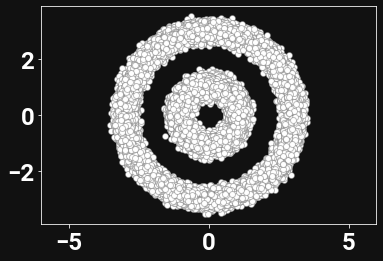

In [5]:
my_scatter(*X.T,c='w',edgecolor='#77777777')
_=plt.axis('equal')

In [6]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=0.6, min_samples=2)

In [7]:
%%time
y_db = db.fit_predict(X)

CPU times: user 16.1 s, sys: 6.63 s, total: 22.7 s
Wall time: 22.7 s


In [8]:
!uptime

 13:49:27 up 19 days, 22:36,  5 users,  load average: 1.56, 1.18, 1.69


In [9]:
print(f'Number of classifier errors: {sum(y_db-y)}')

Number of classifier errors: 0


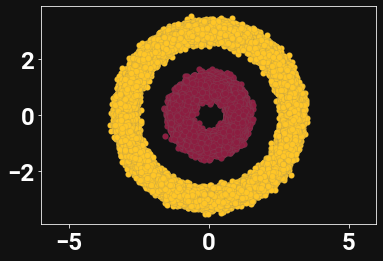

In [10]:
mask0,mask1 = y_db == 0, y_db==1
my_scatter(*X[mask0].T,c=gld,edgecolor='#77777722')
my_scatter(*X[mask1].T,c=mrn,edgecolor='#77777722')
_=plt.axis('equal')

Now on the GPU 
--------------

In [11]:
X_df = pd.DataFrame({'fea%d'%i: X[:, i] for i in range(X.shape[1])})
X_gpu = cudf.from_pandas(X_df)

In [12]:
print(f'Proof on GPU: {X_gpu.values.device}')

Proof on GPU: <CUDA Device 0>


In [13]:
%%time
from cuml import DBSCAN as cumlDBSCAN
db_gpu = cumlDBSCAN(eps=0.6, min_samples=2)

CPU times: user 349 ms, sys: 130 ms, total: 479 ms
Wall time: 884 ms


In [14]:
%%time
y_db_gpu = db_gpu.fit_predict(X_gpu)

CPU times: user 569 ms, sys: 307 ms, total: 876 ms
Wall time: 873 ms


In [15]:
!nvidia-smi

Mon Oct  5 13:49:31 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.152.00   Driver Version: 418.152.00   CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:0A:00.0 Off |                    0 |
| N/A   33C    P0    63W / 300W |    894MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [16]:
print(f'Number of classifier errors: {sum(cupy.asnumpy(y_db_gpu.values)-y)}')

Number of classifier errors: 0


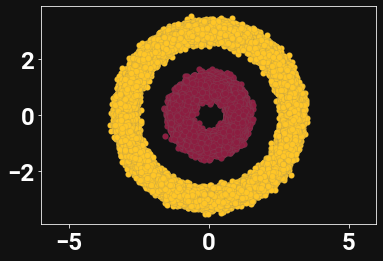

In [17]:
mask0,mask1 = y_db_gpu == 0, y_db_gpu==1
my_scatter(*X_gpu[mask0].as_matrix().T,c=gld,edgecolor='#77777722')
my_scatter(*X_gpu[mask1].as_matrix().T,c=mrn,edgecolor='#77777722')
_=plt.axis('equal')

![](./speedup.png)

https://towardsdatascience.com/heres-how-you-can-accelerate-your-data-science-on-gpu-4ecf99db3430